# 8.2 VGG16 Model training code

In [ ]:
import numpy as np 
import pandas as pd 
import os

import csv

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax, Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add, MaxPool1D,ZeroPadding1D, LSTM
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers

from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data ingestion stage

In [ ]:
os.chdir('drive/MyDrive/Major Project/Customized_Dataset/')
path = ''

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


In [ ]:
window_size = 180
count = 10000

classes = ['N', 'S', 'F', 'V', 'Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Data preparation stage

In [ ]:
filenames = os.listdir()
records = list()
annotations = list()
filenames.sort()

In [ ]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    else:
        annotations.append(path + filename + file_extension)

# Data preprocessing stage

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-8-eb74913cffa6>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-eb74913cffa6>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-eb74913cffa6>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1 and not example_beat_printed:


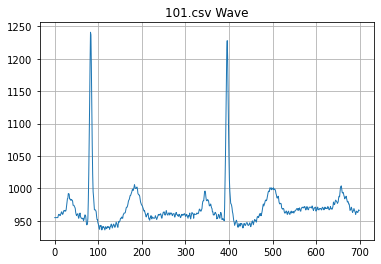

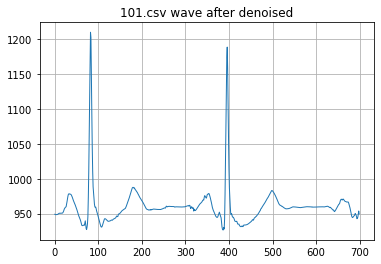

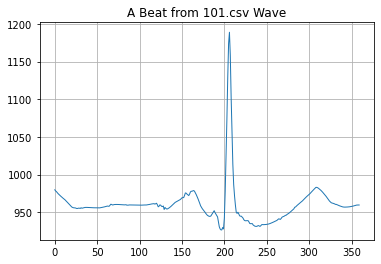

In [ ]:
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r is 1:
        # Plotting ECG graph for each patient
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    
    if r is 1:
        # Plotting ECG graph for each patient
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        

    # Smoothing ECG graph
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted)) 
            arrhythmia_type = next(splitted) 
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)

                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     
                    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

In [ ]:
os.chdir('..')

In [ ]:
X = pd.read_csv('datafile.csv')
y = pd.read_csv('outfile.csv')
print(len(X), len(y))


190959 190959


# Checking for Classes Distribution

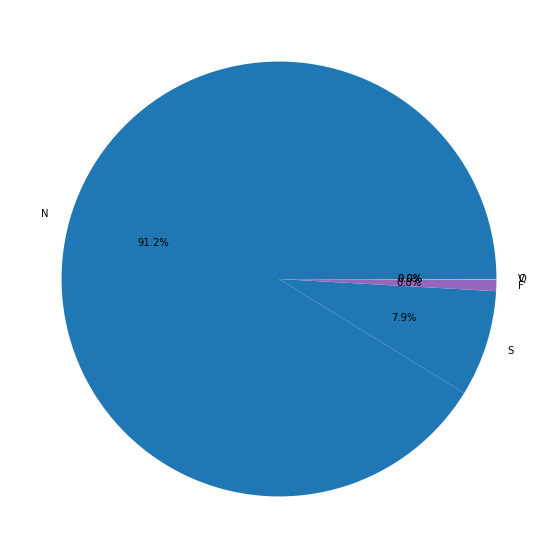

In [ ]:
X_train_df = X.copy()
per_class = X_train_df['360'].value_counts()
# print(per_class)
plt.figure(figsize=(20,10))
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:blue','tab:purple','tab:olive','tab:red'],autopct='%1.1f%%')
p=plt.gcf()
plt.show()

# Solving unbalanced class problem

In [ ]:
df_1=X_train_df[X_train_df['360']==1]
df_2=X_train_df[X_train_df['360']==2]
df_3=X_train_df[X_train_df['360']==3]
df_4=X_train_df[X_train_df['360']==4]

df_0=(X_train_df[X_train_df['360']==0]).sample(n=5000,random_state=42)
df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)

X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

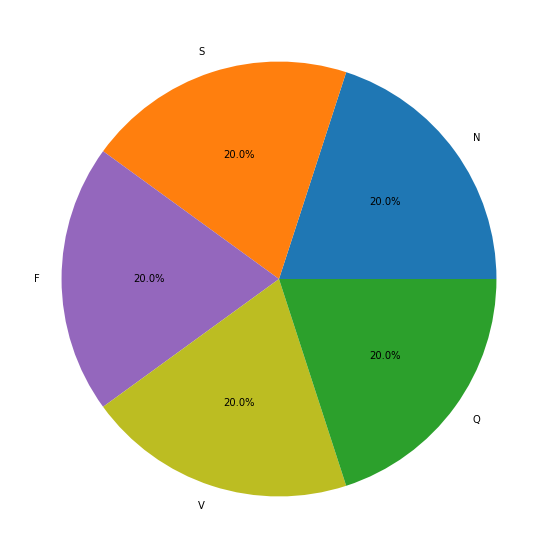

In [ ]:
per_class = X_train_df['360'].value_counts()
# print(per_class)
plt.figure(figsize=(20,10))
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
plt.show()

# Train Test split

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [ ]:
target_train=train['360']
target_test=test['360']
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


# VGG-16 model building

In [ ]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',  input_shape=(360,1)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Flatten())
vgg_16_model.add(Dense(4096, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(4096, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(5, activation='softmax'))

In [ ]:
vgg_16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
vgg_16_model_history = vgg_16_model.fit(train_x, train_y, epochs = 20, batch_size = 100, validation_data = (test_x, test_y))

Epoch 1/20
200/200 [==============================] - 40s 88ms/step - loss: 0.5403 - accuracy: 0.9020 - val_loss: 4.0873 - val_accuracy: 0.3400
Epoch 2/20
200/200 [==============================] - 17s 85ms/step - loss: 0.1276 - accuracy: 0.9582 - val_loss: 0.2888 - val_accuracy: 0.9026
Epoch 3/20
200/200 [==============================] - 17s 87ms/step - loss: 0.1875 - accuracy: 0.9488 - val_loss: 0.2830 - val_accuracy: 0.9334
Epoch 4/20
200/200 [==============================] - 17s 85ms/step - loss: 0.1173 - accuracy: 0.9618 - val_loss: 0.0643 - val_accuracy: 0.9762
Epoch 5/20
200/200 [==============================] - 17s 86ms/step - loss: 0.0755 - accuracy: 0.9758 - val_loss: 0.0474 - val_accuracy: 0.9854
Epoch 6/20
200/200 [==============================] - 17s 86ms/step - loss: 0.0716 - accuracy: 0.9779 - val_loss: 0.6310 - val_accuracy: 0.9506
Epoch 7/20
200/200 [==============================] - 17s 85ms/step - loss: 0.0873 - accuracy: 0.9748 - val_loss: 0.0718 - val_accuracy:

In [ ]:
y_true_vgg=[]
for element in test_y:
    y_true_vgg.append(np.argmax(element))
prediction_proba=vgg_16_model.predict(test_x)
prediction_vgg16=np.argmax(prediction_proba,axis=1)

157/157 [==============================] - 3s 10ms/step


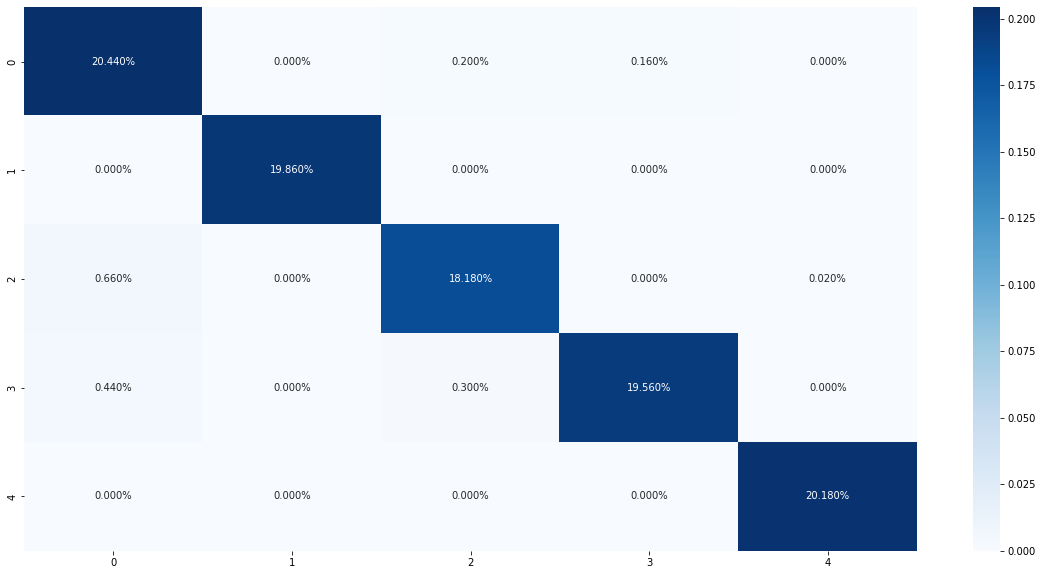

In [ ]:
vggconfmat = confusion_matrix(y_true_vgg, prediction_vgg16)
plt.figure(figsize=(20,10))
sns.heatmap(vggconfmat/np.sum(vggconfmat), annot=True,fmt='.3%', cmap='Blues')
plt.savefig('vgg16ConfMat.png')

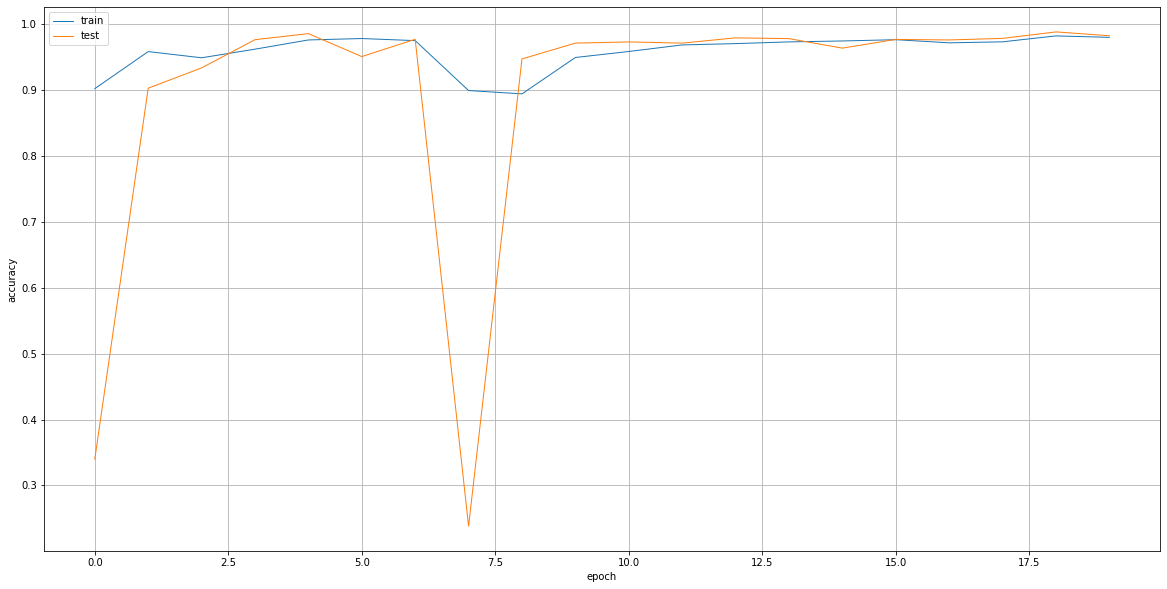

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(vgg_16_model_history.history['accuracy'])
plt.plot(vgg_16_model_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

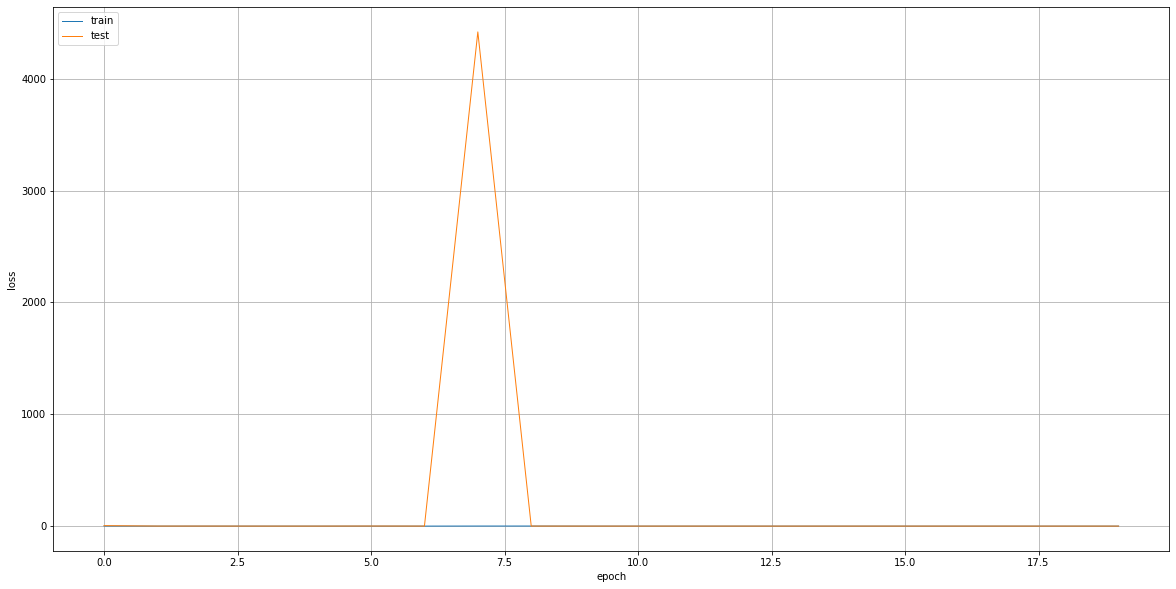

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(vgg_16_model_history.history['loss'])
plt.plot(vgg_16_model_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print('Precision: %.3f' % precision_score(y_true_vgg, prediction_vgg16, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_vgg, prediction_vgg16, average='micro'))
print('Recall: %.3f' % recall_score(y_true_vgg, prediction_vgg16, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_vgg, prediction_vgg16))

Precision: 0.982
F1 Score: 0.982
Recall: 0.982
Accuracy: 0.982


# Save the trained VGG-16 model

In [ ]:
from keras.models import load_model

vgg_16_model.save('my_model.h5')